In [1]:
from triqs.gf import *
from h5 import *
import triqs.utility.mpi as mpi
from triqs.applications.impurity_solvers.ctint_tutorial import CtintSolver
from triqs.plot.mpl_interface import oplot

# Parameters
U = 2.5            # Hubbard interaction
mu = U/2.0         # Chemical potential
half_bandwidth=1.0 # Half bandwidth (energy unit)
beta = 40.0        # Inverse temperature
n_iw = 128         # Number of Matsubara frequencies
n_cycles = 10000   # Number of MC cycles
delta = 0.1        # delta parameter
n_iterations = 21  # Number of DMFT iterations

S = CtintSolver(beta, n_iw) # Initialize the solver

S.G_iw << SemiCircular(half_bandwidth) # Initialize the Green's function

with HDFArchive("dmft_bethe.output.h5",'w') as A:
 A['n_iterations'] = n_iterations # Save a parameter

 for it in range(n_iterations): # DMFT loop
  for name, G0 in S.G0_iw:
   G0 << inverse(iOmega_n + mu - (half_bandwidth/2.0)**2 * S.G_iw[name] ) # Set G0
  # Change random number generator on final iteration
  random_name = 'mt19937' if it<n_iterations-1 else 'lagged_fibonacci19937'

  S.solve(U, delta, n_cycles, random_name=random_name) # Solve the impurity problem

  G_sym = (S.G_iw['up']+S.G_iw['down'])/2 # Impose paramagnetic solution
  S.G_iw << G_sym

  if mpi.is_master_node():
   A['G%i'%it] = G_sym # Save G from every iteration to file

Starting on 1 Nodes at : 2014-10-22 18:06:12.886058


(0, 5)

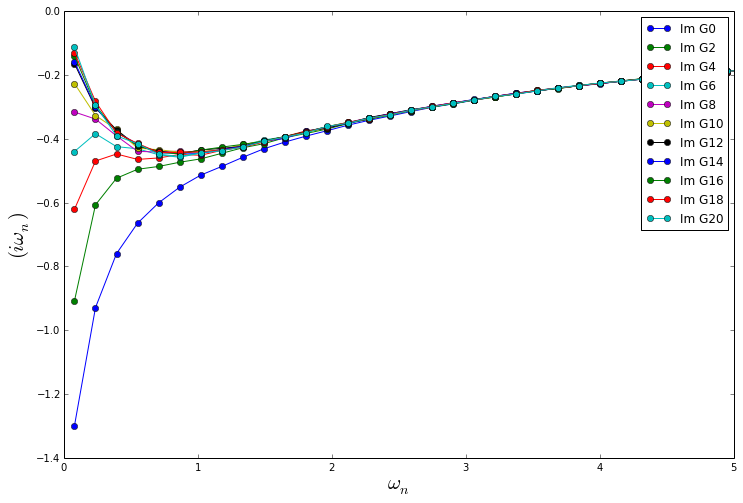

In [2]:
A = HDFArchive("dmft_bethe.output.h5",'r') # Open file
n_iterations = A['n_iterations'] # Load a parameter
for it in range(n_iterations): # Use parameter in the analysis
 if not it%2: oplot(A['G%i'%it].imag, '-o', name='Im G%i'%it) # Plot every second result
xlim(0,5)